In [1]:
#Libraries and Definitions
import gensim
import os
import spacy
import pytextrank
import time
import numpy as np
import seaborn as sns
import string
import matplotlib.pyplot as plt
from string import digits
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]
import pandas as pd
from spacy.lang.en import English
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.base import TransformerMixin
# from sklearn.pipeline import Pipeline
# from sklearn.cluster import AgglomerativeClustering, KMeans
from collections import Counter

####Reset to project folder
os.chdir("/home/n/Dropbox (CSU Fullerton)/539 Consulting/ReviewData")

nlp = spacy.load("en_core_web_md")

tr = pytextrank.TextRank()
nlp.add_pipe(tr.PipelineComponent, name="textrank", last=True)
nlp.Defaults.stop_words |= {"chipotle","i","Chipotle"}

punctuations = string.punctuation
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()
digs = string.digits


translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))


def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)
    mytokens = [ word.lemma_.lower().translate(translator).strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    # mytokens = [chunk.root.text.lower().strip() for chunk in mytokens.noun_chunks]
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations]
    mytokens = [''.join(filter(lambda x: x.isalpha(),word)) for word in mytokens]
    return mytokens



def viz_model(model, modeldict, num_words = 20,print_words=5):
    ntopics = model.num_topics
    top_terms = Counter(modeldict.dfs).most_common(num_words)
    # top words associated with the resulting topics
    topics = ['Topic {}: {}'.format(t,modeldict[w]) for t in range(ntopics) for w,p in model.get_topic_terms(t, topn=1)]
    terms = [modeldict[w] for w,c in top_terms]
    keys = [i for i,c in top_terms]
    matrix = np.log(model.get_topics()[:,keys])
    fig,ax=plt.subplots()
    ax.imshow(matrix)  # plot the numpy matrix
    ax.set_xticks(range(num_words))#modeldict.keys())  # set up the x-axis
    ax.set_xticklabels(terms, rotation=90)
    ax.set_yticks(np.arange(ntopics))  # set up the y-axis
    ax.set_yticklabels(topics)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            text = ax.text(j, i, matrix[i, j].round(1),
                       ha="center", va="center", color="w")
    # fig.tight_layout()
    plt.show()
    print('Perplexity: {:.2f}'.format(model.log_perplexity(bow)))
    # display the top terms for each topic
    for topic in range(ntopics):
        print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=print_words)]))
    # print(topics)

def test_eta(eta, dictionary, ntopics, print_topics=True, print_dist=False):
    np.random.seed(42) # set the random seed for repeatability
    bow = [dictionary.doc2bow(line) for line in doc_list] # get the bow-format lines with the set dictionary
    with (np.errstate(divide='ignore')):  # ignore divide-by-zero warnings
        model = gensim.models.ldamodel.LdaModel(
            corpus=bow, id2word=dictionary, num_topics=ntopics,
            random_state=2, eta=eta,
            update_every=1,
            passes=10, alpha='auto', per_word_topics=True)
    # visuzlize the model term topics
    viz_model(model, dictionary)
    print('Perplexity: {:.2f}'.format(model.log_perplexity(bow)))
    if print_topics:
        # display the top terms for each topic
        for topic in range(ntopics):
            print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=3)]))
    # if print_dist:
    #     # display the topic probabilities for each document
    #     for line,bag in zip(txt,bow):
    #         doc_topics = ['({}, {:.1%})'.format(topic, prob) for topic,prob in model.get_document_topics(bag)]
    #         print('{} {}'.format(line, doc_topics))
    return model

def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

def sentencer(string):
    docs = nlp(string)
    sentences=[]
    for i in docs.sents:
        # doc = nlp(i)
        # mytokens = [word.lower().strip() for word in i.lemma_ if  i.is_stop == False]
        mytokens = [ word.lemma_.lower().translate(translator).strip() if word.lemma_ != "-PRON-" else word.lower_ for word in i ]
        # mytokens = [chunk.root.text.lower().strip() for chunk in i.noun_chunks]
        mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations]
        # mytokens = [''.join(filter(lambda x: x.isalpha(),word)) for word in mytokens]
        # sentences.append(" ".join(mytokens))
        sentences.append(mytokens)
    return(sentences)

def parser2(strings):
    n=np.ceil(len(strings)/5000) #Break into pieces if needed
    split_strings = np.array_split(strings,n)
    split_sent=[]
    for string in split_strings:
        s = " ||| ".join(string) #join all reviews to tag at once (slightly faster)
        doc = nlp(s) #spacy call
        split_inds = [i for i, token in enumerate(doc) if token.text == '|||'] + [len(doc)] #split out reviews
        splits = [doc[(i + 1 if i >0 else i):j].as_doc() for i,j in zip([0]+split_inds[:-1],split_inds)]
        for i in splits:
            split_sent.append(      #split out sentences
                [
                    # [for word in sent]
                    [word.lemma_.lower().strip() for word in sent    #remove any stop words, punct/numerals, and return nouns
                        if  word.text not in stop_words
                            and word.is_alpha == True
                            and word.pos_ in ["NOUN"]]
                     # [chunk.text.lower().strip() for chunk in sent.noun_chunks
                         # if chunk.text not in stop_words]
                 for sent in i.sents]
            )
    return split_sent

In [2]:
reviews = pd.read_csv("combined.csv")
samples = reviews[["ID","Review"]].sample(n=10000,random_state=  1).dropna()


samples["Tokens"] = parser2(samples.Review.values)

In [28]:
samples_long = samples.explode("Tokens").reset_index()

In [29]:

from gensim import models, corpora


doc_list = []
for i in samples_long["Tokens"].fillna(""):
    doc_list.append(i)
dictionary = corpora.Dictionary(doc_list)
bow = [dictionary.doc2bow(doc) for doc in doc_list]
tfidf = models.TfidfModel(bow)

corpus_tfidf = tfidf[bow]

apriori_original = {
    'bowl':0, 'burrito':0, 'rice':0, 'meat':0, 'chips':0, 'guacamole':0, 'chicken':0, 'taco':0,
    'service':1, 'order':1, 'line':1, 'experience':1,
    'location':2, 'place':2, 'restaurant':2,
    'staff':3, 'employees':3,
    'mobile':4, 'online':4,
}
eta = create_eta(apriori_original, dictionary, 10)


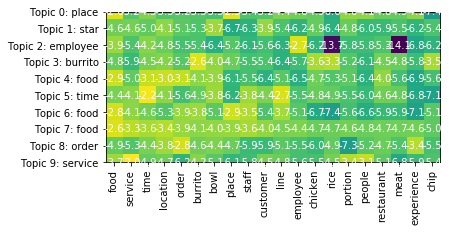

Perplexity: -2.22
Topic 0: ['place', 'food', 'portion', 'people', 'experience', 'thing', 'meal', 'time', 'line', 'today']
Topic 1: ['star', 'bowl', 'customer', 'day', 'location', 'lunch', 'minute', 'money', 'quality', 'service']
Topic 2: ['employee', 'price', 'guacamole', 'food', 'time', 'table', 'hour', 'spot', 'floor', 'meal']
Topic 3: ['burrito', 'rice', 'chip', 'chicken', 'lunch', 'bowl', 'location', 'dinner', 'today', 'time']
Topic 4: ['food', 'location', 'time', 'order', 'bowl', 'restaurant', 'burrito', 'minute', 'steak', 'chicken']
Topic 5: ['time', 'line', 'staff', 'bowl', 'salad', 'location', 'service', 'reason', 'customer', 'food']
Topic 6: ['food', 'place', 'staff', 'line', 'burrito', 'order', 'service', 'store', 'worker', 'star']
Topic 7: ['food', 'service', 'location', 'time', 'staff', 'order', 'place', 'bowl', 'customer', 'burrito']
Topic 8: ['order', 'experience', 'review', 'year', 'location', 'area', 'quality', 'bowl', 'time', 'friend']
Topic 9: ['service', 'people', 'p

In [34]:
#This seems like the best so far, 10 topics, but break them down later
lda_model2 = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                            id2word=dictionary,
                                            num_topics=10,
                                            random_state=2,
                                            update_every=None,
                                            passes=1,
                                            alpha='auto',
                                            eta = eta,
                                            per_word_topics=True
)
viz_model(lda_model2,dictionary,print_words=10)

In [35]:
doc_topics = []
for i in corpus_tfidf:
    doc_topics.append([prob for topic,prob in lda_model2.get_document_topics(i)])

In [36]:
samples_long["TopicProbs"] = doc_topics

In [38]:
topic_names = ["Topic"+str(i) for i in range(10)]
samples_long[topic_names] = pd.DataFrame.from_records(doc_topics,columns=topic_names)

In [44]:
samples_long["Tokens_text"] = [''.join(map(str,l)) for l in samples_long["Tokens"]]

In [48]:

samples_long["HighestTopic"] = samples_long[samples_long["Tokens_text"] != ""].filter(regex = "Topic\d").idxmax(axis=1)

Text(0.5, 1.0, 'Count per Topic Category')

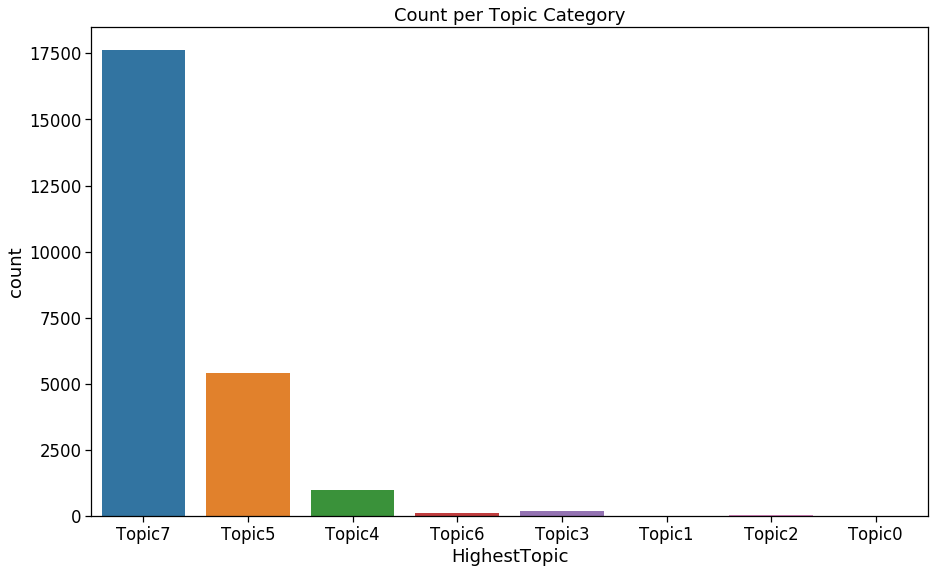

In [57]:
fig,ax=plt.subplots(figsize = (15,9))
sns.countplot(samples_long.HighestTopic)
ax.set_title("Count per Topic Category")

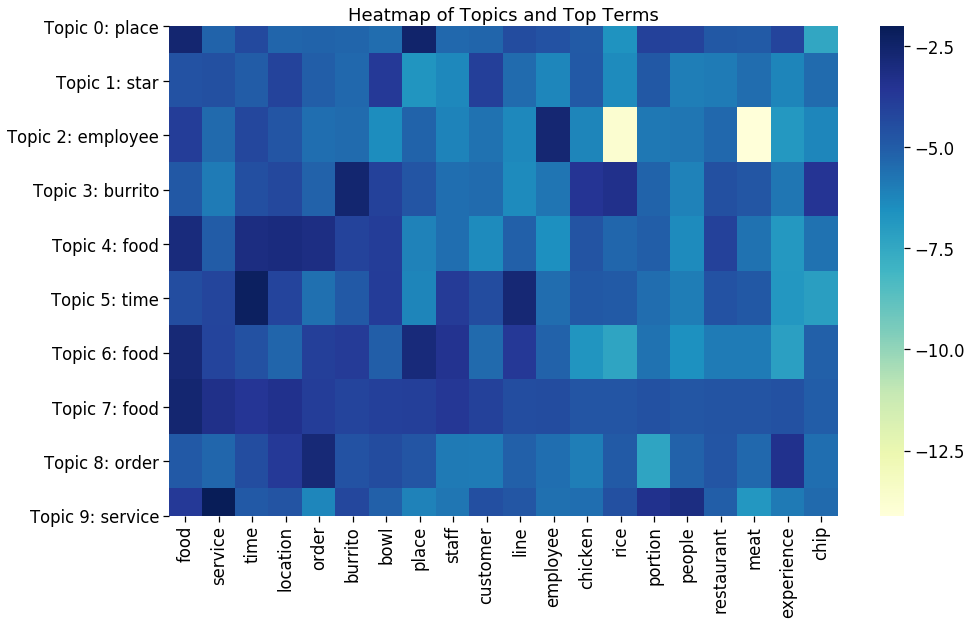

In [50]:
def viz_model2(model, modeldict, num_words = 20,print_words=5):
    ntopics = model.num_topics
    top_terms = Counter(modeldict.dfs).most_common(num_words)
    # top words associated with the resulting topics
    topics = ['Topic {}: {}'.format(t,modeldict[w]) for t in range(ntopics) for w,p in model.get_topic_terms(t, topn=1)]
    terms = [modeldict[w] for w,c in top_terms]
    keys = [i for i,c in top_terms]
    matrix = np.log(model.get_topics()[:,keys])
    df = pd.DataFrame(matrix,columns=terms,index=topics)
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    fig,ax=plt.subplots(figsize = (15,9))
    sns.heatmap(df,xticklabels=1, cmap="YlGnBu")
    ax.set_title("Heatmap of Topics and Top Terms")
#     ax.imshow(matrix)  # plot the numpy matrix
#     ax.set_xticks(range(num_words))#modeldict.keys())  # set up the x-axis
#     ax.set_xticklabels(terms, rotation=90)
#     ax.set_yticks(np.arange(ntopics))  # set up the y-axis
#     ax.set_yticklabels(topics)
#     for i in range(matrix.shape[0]):
#         for j in range(matrix.shape[1]):
#             text = ax.text(j, i, matrix[i, j].round(1),
#                        ha="center", va="center", color="w")
    # fig.tight_layout()
    plt.show()
#     print('Perplexity: {:.2f}'.format(model.log_perplexity(bow)))
    # display the top terms for each topic
#     for topic in range(ntopics):
#         print('Topic {}: {}'.format(topic, [dictionary[w] for w,p in model.get_topic_terms(topic, topn=print_words)]))
    # print(topics)
    
    
viz_model2(lda_model2,dictionary,print_words=10)

In [66]:
Topics_terms = {}
for topic in range(10):
        Topics_terms['Topic'+ str(topic)] =  [dictionary[w] for w,p in lda_model2.get_topic_terms(topic, topn=5)]

In [77]:
Topic_df = pd.DataFrame.from_dict(Topics_terms)
Topic_df[["Topic7","Topic5","Topic4","Topic6","Topic3"]]

,Topic7,Topic5,Topic4,Topic6,Topic3
0,food,time,food,food,burrito
1,service,line,location,place,rice
2,location,staff,time,staff,chip
3,time,bowl,order,line,chicken
4,staff,salad,bowl,burrito,lunch
